In [1]:
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import squareform
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from zipfile import ZipFile

import time
import gzip
import graco
import shutil
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/Users/markusyoussef/Desktop/git/graco/data"

# Downloads

### BioGRID

In [3]:
BioGRID_FILENAME = "BIOGRID-ORGANISM-3.5.177.tab2.zip"
BioGRID_URL = "https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.177"
BioGRID_FILEPATH = f"{DATA_DIRECTORY}/{BioGRID_FILENAME}" 

In [6]:
# Download
r = requests.get(f"{BioGRID_URL}/{BioGRID_FILENAME}", allow_redirects=True)
with open(BioGRID_FILEPATH, 'wb') as f:
    f.write(r.content)

In [7]:
# Unzip Saccharomyces cerevisiae file
with ZipFile(BioGRID_FILEPATH, 'r') as z:
    BioGRID_sc_FILENAME, = [name for name in z.namelist() if 'cerevisiae' in name.lower()]
    z.extract(BioGRID_sc_FILENAME, DATA_DIRECTORY)

### SGD annotations

In [3]:
SGD_FILENAME = "sgd.gaf.gz"
SGD_URL = "http://current.geneontology.org/annotations"
SGD_FILEPATH = f"{DATA_DIRECTORY}/{SGD_FILENAME}"

In [4]:
# Download
r = requests.get(f"{SGD_URL}/{SGD_FILENAME}", allow_redirects=True)
with open(SGD_FILEPATH, 'wb') as f:
    f.write(r.content)

### GO

In [5]:
GO_FILENAME = "go-basic.obo"
GO_URL = "http://purl.obolibrary.org/obo/go"
GO_FILEPATH = f"{DATA_DIRECTORY}/{GO_FILENAME}"

In [6]:
# Download
r = requests.get(f"{GO_URL}/{GO_FILENAME}", allow_redirects=True)
with open(GO_FILEPATH, 'wb') as f:
    f.write(r.content)

# PPI (S. cerevisiae, BioGRID)

### Define interactor universes

In [4]:
# load BioGRID file as dataframe
organism_FILENAME = "BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.177.tab2.txt"
organism_FILEPATH = f"{DATA_DIRECTORY}/{organism_FILENAME}"

# remove entrez ids and scores because of mixed datatypes 
interaction_df = pd.read_csv(organism_FILEPATH, delimiter='\t',
                           usecols=[index for index in range(24) if index not in {1,2,18}])

In [5]:
# BioGRID universe is the collection of every gene known to BioGRID
universe = set(interaction_df['BioGRID ID Interactor A']) | \
           set(interaction_df['BioGRID ID Interactor B'])

systematic_universe = set(interaction_df['Systematic Name Interactor A']) | \
                      set(interaction_df['Systematic Name Interactor B'])
systematic_universe.remove('-')

In [6]:
# Filter for (reliable) physical interactions
EXPERIMENTAL_SYSTEM = {'Two-hybrid', 
                       'Affinity Capture-Luminescence',
                       'Affinity Capture-MS', 
                       'Affinity Capture-RNA', 
                       'Affinity Capture-Western'}
EXPERIMENTAL_SYSTEM_TYPE = {'physical'} # redundant because of experimental evidence filtering

physical_interaction_df = interaction_df[interaction_df['Experimental System'].isin(EXPERIMENTAL_SYSTEM)]
physical_interaction_df = physical_interaction_df[physical_interaction_df['Experimental System Type'].isin(EXPERIMENTAL_SYSTEM_TYPE)] # just in case...


physical_universe = set(physical_interaction_df['BioGRID ID Interactor A']) | \
                            set(physical_interaction_df['BioGRID ID Interactor B'])

systematic_physical_universe = set(physical_interaction_df['Systematic Name Interactor A']) | \
                                       set(physical_interaction_df['Systematic Name Interactor B'])
systematic_physical_universe.remove('-')

### Summary

In [7]:
print("BioGRID universe sizes:")
print("=========================")
print(f"    -         -    : {len(universe)}")
print(f"systematic    -    : {len(systematic_universe)}")
print(f"    -      physical: {len(physical_universe)}")
print(f"systematic physical: {len(systematic_physical_universe)}")

BioGRID universe sizes:
    -         -    : 7172
systematic    -    : 6535
    -      physical: 6551
systematic physical: 6121


### PPI

In [8]:
PPI_df = physical_interaction_df[
    physical_interaction_df["Systematic Name Interactor A"].str.startswith('Y') & \
    physical_interaction_df["Systematic Name Interactor B"].str.startswith('Y')]

PPI_universe = set(PPI_df['Systematic Name Interactor A']) | \
               set(PPI_df['Systematic Name Interactor B'])

In [9]:
PPI_nx = nx.from_pandas_edgelist(PPI_df,'Systematic Name Interactor A', 'Systematic Name Interactor B')
PPI_nx.remove_edges_from(nx.selfloop_edges(PPI_nx))

# SGD annotations

In [25]:
SGD_FILENAME = "sgd.gaf.gz"
SGD_FILEPATH = f"{DATA_DIRECTORY}/{SGD_FILENAME}"

# load SGD gaf-file as dataframe 
with gzip.open(SGD_FILEPATH, 'rt') as gz:
    gaf_df = pd.DataFrame(annotation for annotation in GOA.gafiterator(gz))
    
# define column with systematic gene names
gaf_df['Systematic_ID']  = gaf_df.Synonym.apply(
    lambda list_ : next(iter(set(list_) & systematic_universe), np.nan))

# Filter for proteins
gaf_df = gaf_df.dropna()
gaf_df = gaf_df[gaf_df['Systematic_ID'].str.startswith('Y')]

## GO, annulus2GO

In [8]:
# Load obo and gaf files
GO_FILENAME = "go-basic.obo"
GO_FILEPATH = f"{DATA_DIRECTORY}/{GO_FILENAME}"

# Define dictionary of all upstream go-terms
go_dag = obo_parser.GODag(GO_FILEPATH)
go2parents = {go_id:set(go_dag[go_id].get_all_parents()) | {go_id} for go_id in go_dag.keys()}

# Filter through evidence code and GO-term namespace
gaf_df = gaf_df[gaf_df['Evidence'].isin(['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP'])]
gaf_df = gaf_df[gaf_df['Aspect']=='P']

# Extract annotation dataframe
specific_annotations = gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()

# Create annotations with all upstream terms in list
all_annotations_list = [(gene_id, go_term, go_dag[go_term].level) 
                                for _, (gene_id, go_id) in specific_annotations.iterrows()
                                    for go_term in go2parents[go_id]]

# Convert annotation list to dataframe
all_annotations_df = pd.DataFrame(
                            all_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()

# Remove level 0 annotations
all_annotations_df = all_annotations_df[all_annotations_df.Level != 0]

PPI_annotations_df = all_annotations_df[all_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]

/Users/markusyoussef/Desktop/git/graco/data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


NameError: name 'gaf_df' is not defined

## Similarity matrices

### GraCo similarity

In [5]:
int2gene = dict(enumerate(PPI_nx))
gene2int = {gene:n for n,gene in int2gene.items()}

# Get orbit-specific graphlet coefficients
GDV  = graco.orbits(PPI_nx)
GCCV = graco.clusterings(PPI_nx)

C0 = np.array(GCCV[['c_02', 'c_03']])
C1 = np.array(GCCV[['c_15', 'c_18', 'c_110', 'c_112']])
C2 = np.array(GCCV[['c_27', 'c_211', 'c_213']])
C3 = np.array(GCCV[['c_311', 'c_313', 'c_314']])

In [31]:
def graco_distance(i, j):
    return sum(graco.functions.tvd(C[i],C[j])/C_len for C in C_list)

# Chose TVD combination
numbers = [0]
C_list = [eval(f'C{nr}') for nr in numbers]
C_len  = len(C_list)

# Calculate TVD matrix
N = PPI_nx.number_of_nodes()
sqD = squareform(np.zeros([N,N]))

t1 = time.time()
for nr, (i,j) in enumerate(combinations(range(N), 2)):
    sqD[nr] = graco_distance(i,j)
    
    if nr % 10000 == 0:
        t2 = time.time()
        print(f'{N} Nodes: {200*(nr+1)/(N*(N-1)):.2f}% - {t2-t1:.2f}sec', end='\r')
        
t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_tvd = squareform(sqD)

In [32]:
t1 = time.time()
sqD = [graco.functions.tvd(C0[i],C0[j]) for (i,j) in combinations(range(N), 2)]
t2 = time.time()
print(t2-t1)

150.2326033115387


In [34]:
(D_tvd == squareform(sqD)).all()

True

### Signature similarity

In [70]:
LogGDV = np.log(np.array(GDV+1))

orbit_dependencies = np.array((1,2,2,2,3,4,3,3,4,3,4,4,4,4,3))
weights = 1 - np.log(orbit_dependencies) / np.log(len(orbit_dependencies))
weight_sum = np.sum(weights)

In [74]:
# Calculate signature distance matrix
N = PPI_nx.number_of_nodes()
D = np.zeros([N,N])

t1 = time.time()
for (i,j) in combinations(range(N), 2):
    u = GDV.iloc[i]
    v = GDV.iloc[j]
    d = weights*np.abs(LogGDV[i,:]-LogGDV[j,:]) / np.log(np.max([u,v], axis=0)+2)

    sqD[nr] = np.sum(d)
    if nr % 10000 == 0:
        t2 = time.time()
        print(f'{N} Nodes: {200*(nr+1)/(N*(N-1)):.2f}% - {t2-t1:.2f}sec', end='\r')

t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_signature = squareform(sqD) / weight_sum

---

In [7]:
S_tvd = 1-D_tvd
L_tvd = -S_tvd
np.fill_diagonal(L_tvd, np.sum(S_tvd, axis=0)-1)
diag = np.diag(L).reshape(1, -1)**(-1/2)
L0_tvd = diag.T * L * diag

In [8]:
spec0_tvd, Basis0_tvd = eigh(L0_tvd)
Basis0_tvd = Basis0_tvd[:,np.argsort(spec0_tvd)]
spec0_tvd = spec0_tvd[np.argsort(spec0_tvd)]

---

## Enrichement analysis

In [10]:
def p_value(GO_term_nr, 
            cluster_nr, 
            list_of_success_states,
            list_of_draws,
            list_of_observed_successes):
    
    success_states = list_of_success_states[GO_term_nr]
    draws = list_of_draws[cluster_nr]
    observed_successes = list_of_observed_successes[GO_term_nr][cluster_nr]

    K = len(success_states)
    n = len(draws)
    k = len(observed_successes)
    
    return 1-hypergeom.cdf(k-1, N, n, K)

In [11]:
# Cluster independent variables

GO_population = set(PPI_annotations_df.GO_ID)
PPI_population = set(PPI_nx.nodes())

int2GO = dict(enumerate(GO_population))
GO2int = {gene:n for n,gene in int2GO.items()}

dict_of_success_states = {go_id:set(PPI_annotations_df.Systematic_ID[PPI_annotations_df.GO_ID == go_id])
                              for go_id in GO_population}
list_of_success_states = list(dict_of_success_states.values())

In [12]:
N = len(PPI_population)
alpha = [0.01, 0.05, 0.1]
m1    = len(GO_population)

MAX_CLUSTER = 10

In [13]:
kmedoid_high_coverage = []
kmedoid_middle_coverage = []
kmedoid_low_coverage = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmedoids_instance = kmedoids(D, range(cluster_nr), data_type = 'distance_matrix')
    kmedoids_instance.process()
    int_clusters  = kmedoids_instance.get_clusters()

    
    kmedoid_clusters = [{int2gene[i] for i in int_cluster} for int_cluster in int_clusters]

    
    list_of_kmedoid_draws = [set(kmedoid_clusters[i]) for i in range(cluster_nr)]

    list_of_kmedoid_observed_successes = [[draws & success_states for draws in list_of_kmedoid_draws]
                                            for success_states in list_of_success_states]
        
    kmedoid_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_kmedoid_draws,
                        list_of_observed_successes=list_of_kmedoid_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    kmedoid_GO_enrichment_df = pd.DataFrame(kmedoid_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    kmedoid_high_significant_enrichment_df   = kmedoid_GO_enrichment_df < alpha[0]/m
    kmedoid_middle_significant_enrichment_df = kmedoid_GO_enrichment_df < alpha[1]/m
    kmedoid_low_significant_enrichment_df    = kmedoid_GO_enrichment_df < alpha[2]/m
    
    kmedoid_high_coverage.append(  sum(kmedoid_high_significant_enrichment_df.any())  /cluster_nr)
    kmedoid_middle_coverage.append(sum(kmedoid_middle_significant_enrichment_df.any())/cluster_nr)
    kmedoid_low_coverage.append(   sum(kmedoid_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 6.80sec
4: 13.46sec
5: 20.31sec
6: 27.30sec
7: 34.50sec
8: 42.07sec
9: 49.53sec


In [14]:
spectral_high_coverage = []
spectral_middle_coverage = []
spectral_low_coverage = []
# kmedoid_coverage  = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmeans = KMeans(n_clusters=cluster_nr)
    kmeans.fit(Basis0[:,1:cluster_nr])
    
    spectral_clusters = [{int2gene[i] for i, x in enumerate(kmeans.labels_) if x == cluster_nr}
                        for cluster_nr in range(cluster_nr)]
    
    list_of_spectral_draws = [set(spectral_clusters[i]) for i in range(cluster_nr)]
    list_of_spectral_observed_successes = [[draws & success_states for draws in list_of_spectral_draws]
                                        for success_states in list_of_success_states]

    spectral_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_spectral_draws,
                        list_of_observed_successes=list_of_spectral_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    spectral_GO_enrichment_df = pd.DataFrame(spectral_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    spectral_high_significant_enrichment_df   = spectral_GO_enrichment_df < alpha[0]/m
    spectral_middle_significant_enrichment_df = spectral_GO_enrichment_df < alpha[1]/m
    spectral_low_significant_enrichment_df    = spectral_GO_enrichment_df < alpha[2]/m
    
    spectral_high_coverage.append(  sum(spectral_high_significant_enrichment_df.any())  /cluster_nr)
    spectral_middle_coverage.append(sum(spectral_middle_significant_enrichment_df.any())/cluster_nr)
    spectral_low_coverage.append(   sum(spectral_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 0.96sec
4: 2.39sec
5: 4.03sec
6: 6.05sec
7: 8.50sec
8: 11.04sec
9: 13.97sec


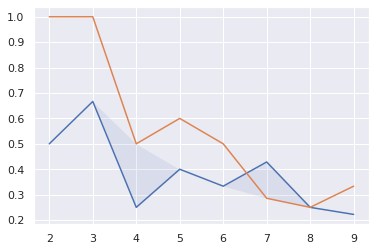

In [15]:
plt.plot(range(2,MAX_CLUSTER), spectral_middle_coverage);
plt.fill_between(range(2,MAX_CLUSTER), spectral_high_coverage, spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), kmedoid_middle_coverage);
plt.fill_between(range(2,MAX_CLUSTER), kmedoid_high_coverage, kmedoid_low_coverage, alpha=0.1);